## 2.6 사이킷런으로 수행하는 타이타닉 생존자 예측

Numpy, Pandas와 함께 그림을 그리기 위해 matplotlib, seaborn 패키지도 불러오자.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

그림 그리는데 딱히 상관없음.

타이타닉 데이터에 대한 설명은 132쪽을 보라. 열두개의 변수 가운데 `survived, pclass, sex, cabin, embarked`는 범주형 변수로 볼 수 있다.

In [2]:
titanic_df = pd.read_csv('./titanic_train.csv')
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


아래에서 보듯 타이타닉 데이터는 12개의 변수와 891개의 case로 이루어져있는데 Age, Cabin, Embarked 변수는 Null값을 갖고 있다. 

In [3]:
print('\n ### train 데이터 정보 ###  \n')
print(titanic_df.info())


 ### train 데이터 정보 ###  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


그런데 사이킷런 머신러닝에서는 Null값을 허용하지 않으므로 그 값들을 다른 값으로 대체해야한다. **fillna(대체할 값, inplace=True)**를 이용해보자. 교재의 코드에서는 나이 변수에 있는 Null은 평균값으로, 그리고 Cabin, Embarked에 있는 Null은 'N'이라는 문자로 모두 대체한다. 그런 다음에도 Null값이 남아있는지 **isnull()**로 확인한다.

In [8]:
titanic_df['Age'].fillna(titanic_df['Age'].mean(),inplace=True)
titanic_df['Cabin'].fillna('N',inplace=True)
titanic_df['Embarked'].fillna('N',inplace=True)
print('데이터 세트 Null 값 갯수 ',titanic_df.isnull().sum().sum())

데이터 세트 Null 값 갯수  0


이어서 범주형 변수들의 빈도분포를 **value_counts()**를 써서 알아볼 수 있다. 

In [10]:
print(' Sex 값 분포 :\n',titanic_df['Sex'].value_counts())
print('\n Cabin 값 분포 :\n',titanic_df['Cabin'].value_counts())
print('\n Embarked 값 분포 :\n',titanic_df['Embarked'].value_counts())

 Sex 값 분포 :
 male      577
female    314
Name: Sex, dtype: int64

 Cabin 값 분포 :
 N              687
G6               4
C23 C25 C27      4
B96 B98          4
E101             3
              ... 
D6               1
C54              1
B82 B84          1
D30              1
D47              1
Name: Cabin, Length: 148, dtype: int64

 Embarked 값 분포 :
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


출력을 보면 Cabin 변수는 범주가 너무 많아서 빈도를 알아보기에 적절하지 못하다. 그 변수의 첫번째 글자(선실의 등급을 나타낸다)만 포함하는 새로운 변수를 만들어보자.

In [13]:
titanic_df['Cabin'] = titanic_df['Cabin'].str[0]

**참고** : 위의 코드 맨 마지막에 나오는 **str**은 판다스 Series의 문자열 항목들을 다루는 함수다. 아래 예를 보라.

In [11]:
list1 = ['abc', 'klmnop', 'kyungsung', '대연동', '4670']
s = pd.Series(list1)
s

0          abc
1       klmnop
2    kyungsung
3          대연동
4         4670
dtype: object

In [12]:
s.str[:2]

0    ab
1    kl
2    ky
3    대연
4    46
dtype: object

이제 Cabin 변수 범주들의 빈도를 알아보자.

In [14]:
titanic_df['Cabin'].value_counts()

N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

타이타닉 데이터에서 label은 생사를 타나내는 변수(Survived)다. 이제 성별, 선실 등급 등에 따라 생존률이 어떻게 다른지 살펴보자. pandas DataFrame을 범주형 변수의 값에 따라 따로 처리할 때 쓰는 **groupby**를 이용하면 된다. 아래 코드는 titanic_df에 있는 Survived `변수 범주의 빈도`를 Sex 변수와 Survived 변수의` 범주에 따라 나누어 보여준다.`

In [15]:
titanic_df.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

위의 결과로부터 남성보다 여성의 생존율이 높은 것을 알 수 있다. 그림으로 살펴보자. 막대에 그려진 세로 선은 무엇을 나타낼까?

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

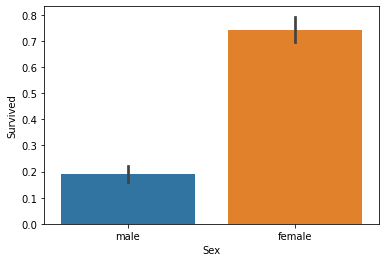

In [16]:
sns.barplot(x='Sex', y = 'Survived', data=titanic_df)

성별과 선실 등급에 따른 생존율도 그려서 결과를 해석해보자. 

barplot() 안에 있는 hue= 의 역할은 무엇일까? **hue**라는 단어의 사전적인 의미는 `빛깔, 색조` 등이다.

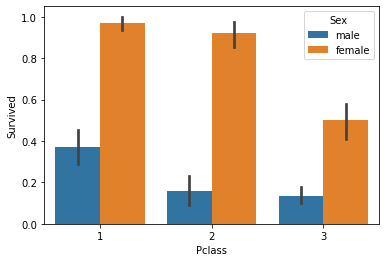

In [17]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)
plt.show()

연령 집단을 나눈 다음, 성별 연령대별 생존율도 그려보자.

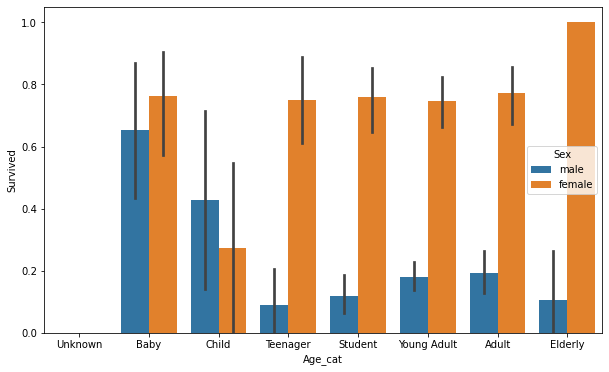

In [18]:
# 입력 age에 따라 구분값을 반환하는 함수 설정. DataFrame의 apply lambda식에 사용. 
def get_category(age):
    cat = ''
    if age <= -1: cat = 'Unknown'
    elif age <= 5: cat = 'Baby'
    elif age <= 12: cat = 'Child'
    elif age <= 18: cat = 'Teenager'
    elif age <= 25: cat = 'Student'
    elif age <= 35: cat = 'Young Adult'
    elif age <= 60: cat = 'Adult'
    else : cat = 'Elderly'
    
    return cat

# 막대그래프의 크기 figure를 더 크게 설정 
plt.figure(figsize=(10,6))

#X축의 값을 순차적으로 표시하기 위한 설정 
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

# lambda 식에 위에서 생성한 get_category( ) 함수를 반환값으로 지정. 
# get_category(X)는 입력값으로 'Age' 컬럼값을 받아서 해당하는 cat 반환
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_category(x))
sns.barplot(x='Age_cat', y = 'Survived', hue='Sex', data=titanic_df, order=group_names)
titanic_df.drop('Age_cat', axis=1, inplace=True)

다음으로 범주형 변수 가운데 Cabin, Sex, Embarked를 숫자 변수로 encoding하자.

In [19]:
from sklearn import preprocessing

def encode_features(dataDF):
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
        
    return dataDF

titanic_df = encode_features(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


지금까지의 전처리 과정을 함수로 정의해서 모아보자.

In [2]:
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

# 레이블 인코딩 수행. 
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

위의 코드에서 맨 아래에 있는 **transform_features()** `함수가 Null 값 변환`, `불필요한 feature 제거`, `범주형 변수 label encoding` 등 데이터 **전처리 과정을 수행하는 함수다.** 타이타닉 데이터를 불러와서 feature data set(X_titanic_df)과 종속변수인 class data set(y_titanic_df)을 만들고 transform_features() 함수를 이용하여 전처리하자.

In [3]:
# 원본 데이터를 재로딩 하고, feature데이터 셋과 Label 데이터 셋 추출. 
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived',axis=1)

X_titanic_df = transform_features(X_titanic_df)

In [4]:
X_titanic_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.000000,1,0,7.2500,7,3
1,1,0,38.000000,1,0,71.2833,2,0
2,3,0,26.000000,0,0,7.9250,7,3
3,1,0,35.000000,1,0,53.1000,2,3
4,3,1,35.000000,0,0,8.0500,7,3
...,...,...,...,...,...,...,...,...
886,2,1,27.000000,0,0,13.0000,7,3
887,1,0,19.000000,0,0,30.0000,1,3
888,3,0,29.699118,1,2,23.4500,7,3
889,1,1,26.000000,0,0,30.0000,2,0


이어서 `y_titanic_df, X_titanic_df`를 train, test 데이터로 나누자. 

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

결정트리, Random Forest, `로지스틱 회귀 방법`으로 분류, 예측 연습을 해보자.(자세한 내용은 4장 이후에 공부한다).

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 결정트리, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train , y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train , y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도:{0:.4f}'.format(accuracy_score(y_test, rf_pred)))

# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train , y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))


DecisionTreeClassifier 정확도: 0.7877
RandomForestClassifier 정확도:0.8547
LogisticRegression 정확도: 0.8492


나무모형을 대상으로 **KFold**를 이용한 교차 검증도 연습해보자.

In [25]:
from sklearn.model_selection import KFold

def exec_kfold(clf, folds=5):
    # 폴드 세트를 5개인 KFold객체를 생성, 폴드 수만큼 예측결과 저장을 위한  리스트 객체 생성.
    kfold = KFold(n_splits=folds)
    scores = []
    
    # KFold 교차 검증 수행. 
    for iter_count , (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
        # X_titanic_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
        X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
        y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
        
        # Classifier 학습, 예측, 정확도 계산 
        clf.fit(X_train, y_train) 
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))     
    
    # 5개 fold에서의 평균 정확도 계산. 
    mean_score = np.mean(scores)
    print("평균 정확도: {0:.4f}".format(mean_score)) 
# exec_kfold 호출
exec_kfold(dt_clf , folds=5) 

교차 검증 0 정확도: 0.7542
교차 검증 1 정확도: 0.7809
교차 검증 2 정확도: 0.7865
교차 검증 3 정확도: 0.7697
교차 검증 4 정확도: 0.8202
평균 정확도: 0.7823


In [26]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_titanic_df , y_titanic_df , cv=5)
for iter_count,accuracy in enumerate(scores):
    print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))

print("평균 정확도: {0:.4f}".format(np.mean(scores)))

교차 검증 0 정확도: 0.7430
교차 검증 1 정확도: 0.7753
교차 검증 2 정확도: 0.7921
교차 검증 3 정확도: 0.7865
교차 검증 4 정확도: 0.8427
평균 정확도: 0.7879


마지막으로 **GridSearchCV**을 이용하여 최적 hyper parameter를 찾는 연습도 해보자.

parameters = {'max_depth':[2,3,5,10],
             'min_samples_split':[2,3,5], 'min_samples_leaf':[1,5,8]}
4장에서 자세히 할것.

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2,3,5,10],
             'min_samples_split':[2,3,5], 'min_samples_leaf':[1,5,8]}

grid_dclf = GridSearchCV(dt_clf , param_grid=parameters , scoring='accuracy' , cv=5)
grid_dclf.fit(X_train , y_train)

print('GridSearchCV 최적 하이퍼 파라미터 :',grid_dclf.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행. 
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test , dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy))

- 참고 4장에서 결정트리 모델을 공부하면 Graphviz 패키지를 이용해서 그래프도 그릴 것이다. (교재 192쪽 같은)

In [ ]:
dt_clf = DecisionTreeClassifier(max_depth = 3, random_state=11)

dt_clf.fit(X_train , y_train)

from sklearn.tree import plot_tree
plot_tree(dt_clf, filled=True, fontsize=5)

그림이 제대로 보이지도 않는다. 이번에는 graph visualization software [Graphviz](https://graphviz.org/)를 이용해서 다시 그려보자. Jupyter notebook에서 Graphviz를 이용하려면 prompt에서 아래와 같이 입력해서 패키지를 설치해야한다. (Colab에서는 설치할 필요없다).

`conda install python-graphviz`

그런 다음 아래와 같이 sklearn.tree 안에 있는 export_graphviz() 함수를 부른다. 이 함수는 `out_file=" "`에서 지정한 이름의 dot 언어로 된 .dot 파일을 만들어준다. Graphviz는 이렇게 만든 dot 파일을 읽어들여서 그래프로 시각화한다. 

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

export_graphviz(dt_clf, out_file="tree.dot", impurity=True, filled=True)

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

여기서 잠깐, dot file이란 무엇이고 Graphviz로 dot 파일을 읽어서 그래프를 어떻게 그릴 수 있다는 것일까? 먼저 Wikipedia에서 ['dot file'](https://en.wikipedia.org/wiki/DOT_(graph_description_language)) 항목을 찾아보자. dot은 그래프를 정의하는 언어이다. 어렵게 생각하지 말고 위키피디아의 첫번째 예를 갖고 와서 직접 그래프를 그려보자. (아래 코드에서 `graphname`과 `;`은 없어도 된다.)

``` graph graphname {
    a -- b -- c;
    b -- d;
}```

위의 문자열 코드를 `graphviz.Source()` 안에 넣기만 하면 바로 그래프가 만들어진다. 

In [ ]:
graphviz.Source("graph { a -- b -- c;  b -- d; }")

화살표가 있는 그래프(directed graph)을 그리고 싶다면 `--`를 `->`로 바꾸고 맨 앞의 `graph`를 `digraph`로 바꾸기만 하면 된다.

In [ ]:
graphviz.Source("digraph { a[shape = box, label=경성] a -> b -> c  b -> d }")

즉 사이킷런의 export_graphviz는 이런 dot file을 만들어주는 함수이고 우리는 graphviz를 이용해서 그 파일을 그래프로 나타낼 수 있다.

* 결정 트리 모델의 특징과 parameter
 + 결정트리의 장단점은 78쪽에 간단히 정리되어있다. 가장 큰 단점은 과대적합의 위험이 크다는 점이다. 즉 나무가 너무 복잡해질 수 있다는 것이다. 이러한 과대적합 문제를 피하기 위해 몇 가지 parameter를 지정할 수 있는데 특히 max_depth, min_samples_split, min_samples_leaf 등이 중요하게 쓰인다.    
   - max_depth는 최대 깊이, 
   + min_samples_split는 더 이상 분리하지 않을 최소 데이터수,
   + min_samples_leaf는 최종 leaf node가 될 수 있는 최소 데이터 수를 의미한다. 